In [1]:
# For interactive plots, comment the next line
%pylab inline
# For interactive plots, uncomment the next line
# %pylab ipympl
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Introduction

This notebook demonstrates how to combine data from multiple sources in an algorithm.

<small>*For instructions on using Jupyter notebooks, see the [README.md](../../README.md) file.*</small>

## Setup

Make sure you have PODPAC properly installed with the **datatype** and **algorithms** optional dependencies:

```
$ pip install podpac[datatype]
$ pip install podpac[algorithms]
```

# Set up data source nodes

See [001-open-raster-file.ipynb](001-open-raster-file.ipynb) for more details on the following data sources.

## Create node for elevation file

This reads a GeoTIFF file using `podpac.data.Rasterio` node (uses `GDAL` internally).

The coordinates of the data can be automatically inferred for this type of file. 

In [2]:
import podpac

# Elevation file
srtm = podpac.data.Rasterio(source='../../data/raster/n39_w107_1arc_v2.tif')
srtm.native_coordinates

Coordinates (EPSG:4326)
	lat: UniformCoordinates1d(lat): Bounds[38.99986111111111, 40.000138888888884], N[3601], ctype['midpoint']
	lon: UniformCoordinates1d(lon): Bounds[-107.00013888888888, -105.9998611111111], N[3601], ctype['midpoint']

## Create node for SMAP file

This reads an HDF5 file using the `H5PY` library.

As in [001-open-raster-file.ipynb](001-open-raster-file.ipynb), we need to define the native coordinates and data key.

In [3]:
# Define a new class, inheriting from the PODPAC H5PY class
class SMAPH5(podpac.data.H5PY):
    # Tell PODPAC where the data is stored in the file
    datakey = '/Analysis_Data/sm_surface_analysis'
    
    # Overwrite the 'get_native_coordinates' function to tell PODPAC about the coordinates of the data
    def get_native_coordinates(self):
        lat = self.dataset['cell_lat'][:, 0]
        lon = self.dataset['cell_lon'][0, :]
        return podpac.Coordinates([lat, lon], dims=['lat', 'lon'])

With this class defined, we can read any file from this dataset.

In [4]:
# SMAP file
smap = SMAPH5(source='../../data/raster/SMAP_L4_SM_aup_20181027T090000_Vv4030_001.h5',
              nan_vals=[-9999],
              interpolation='bilinear')
smap.native_coordinates

Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[-84.65644073486328, 84.65644073486328], N[1624], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-179.9533233642578, 179.9533233642578], N[3856], ctype['midpoint']

# Create Algorithm Node

In [5]:
import traitlets as tl     # the traitlets library is used to enforce input types

# Create a new class, inheriting from Algorithm node
class WetElevation(podpac.algorithm.Algorithm):
    
    # Define the inputs as PODPAC nodes
    elevation = tl.Instance(podpac.Node)
    soil_moisture = tl.Instance(podpac.Node)
    
    # Define the algorithm
    # Note, "inputs" is a dictionary with keys corresponding to any class attributes 
    # of type "Node", in this case 'elevation', and 'soil_moisture'
    def algorithm(self, inputs):
        
        # See if wetter soil_moisture is found at lower elevation
        median_sm = inputs['soil_moisture'].median()
        median_elev = inputs['elevation'].median()
        
        return (inputs['soil_moisture'] > median_sm) & (inputs['elevation'] <= median_elev)

## Evaluate Algorithm

* The elevation file and SMAP file are on different grids
* PODPAC will automatically handle this discrepancy

In [6]:
# Make an instance of the algorithm
wet_elevation = WetElevation(elevation=srtm, soil_moisture=smap)

# Use the elevation's spatial coordinates
coords = srtm.native_coordinates

# Evaluate nodes
o_wet_elevation = wet_elevation.eval(coords)
o_smap = smap.eval(coords)
o_elevation = srtm.eval(coords)

## Plotting Results / Analysis

In [7]:
# Make a custom colormap
cmap = mpl.colors.LinearSegmentedColormap.from_list('namehere', [(1, 1, 1), (0.2, 0.2, 0.7), (0.2, 0.7, 0.2), (1, 1, 0.0)], 4)
norm =  mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

skip = 4  # Plot every 4th data point in both directions (For speed)

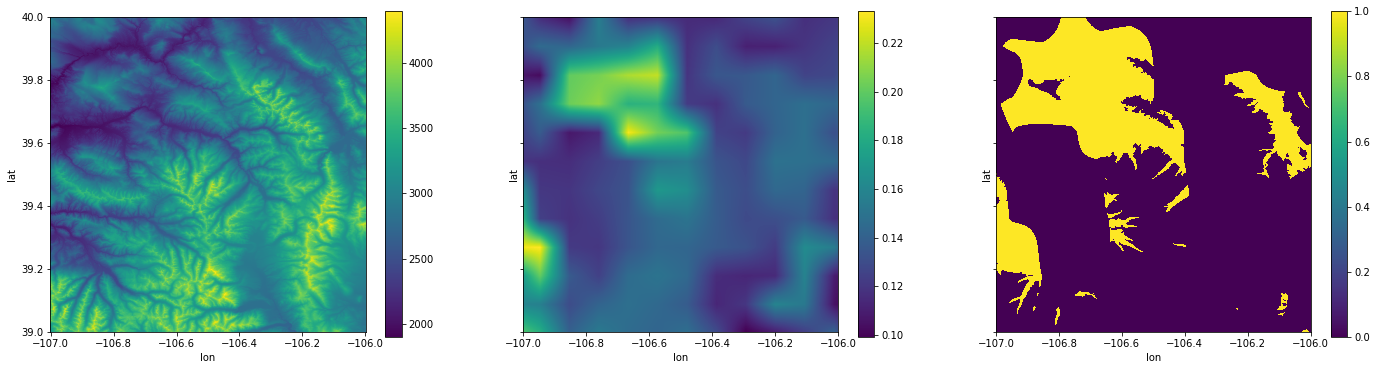

In [9]:
# Configure the plot using matplotlib
fig, axes = plt.subplots(ncols=3, nrows=1, sharex=True, sharey=True, figsize=(24, 6))
plt.setp(axes.flat, aspect=1.0, adjustable='box')

# plot data (this will take a while on slow machines)
o_elevation.plot(ax=axes[0])
o_smap.plot(ax=axes[1])
o_wet_elevation.plot(ax=axes[2])

pass

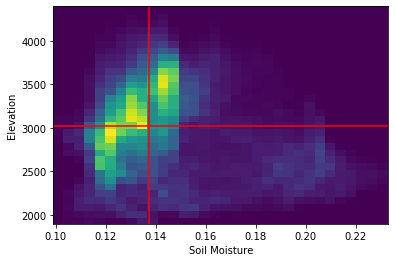

In [10]:
# We can can also plot a 2d histogram of the outputs to examine trends
figure()
hist2d(o_smap.data.ravel(),  # This takes the 2D data and 'unravels' it to a 1D array
       o_elevation.data.ravel(), bins=32)
plot([o_smap.median(), o_smap.median()], [o_elevation.min(), o_elevation.max()], 'r')
plot([o_smap.min(), o_smap.max()], [o_elevation.median(), o_elevation.median()], 'r')
xlabel('Soil Moisture')
ylabel('Elevation')
pass